# Building a Simple Energy Model

The goal of this tutorial is to build a simple energy model using `MESSAGEix` with minimal features that can be expanded in future tutorials. We will build the model component by component, focusing on both the **how** (code implementation) and **why** (mathematical formulation).

# Follow Along at Home

The full model documentation is available online at [https://messageix.iiasa.ac.at](https://messageix.iiasa.ac.at)
    
<img src='assests/doc_page.png'>

And you can easily install `MESSAGEix` yourself and get all the tutorials:

```shell
$ conda install -c conda-forge message-ix
$ messageix-dl # install all tutorials to your current directory
```

TODO, brief primer on message as optimization minimum cost, parameters, constraints, etc.
vars are CAPS, pars are lower_case

# A Brave New World: Westeros with Electricity!

<table><tr><td><img src='assests/westeros.jpg' width='150'></td><td><img src='assests/base_res.png'></td></tr></table>

## Setup

First, we import all the packages we need.

In [1]:
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df

%matplotlib inline

The `Platform` is your connection to a database

In [2]:
mp = ix.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at '/Users/gidden/.local/ixmp/localdb/default'


Once connected, we make our `Scenario` which we use to build our model.

In [3]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', scen='baseline', version='new')

## Model Structure

We start by defining basic characteristics of the model, including time, space, and the energy system structure.

The model horizon will span 3 decades. Let's assume that we're far in the future after the events of A Song of Ice and Fire (which occur ~300 years after Aegon the conqueror).

| Math Notation | Model Meaning                |
|---------------|------------------------------|
| $y \in Y^M$   | time periods in model horizon|

In [4]:
horizon = [700, 710, 720]
scenario.add_horizon({'year': horizon})

Our model will have a single `node`, i.e., its spatial dimension.


| Math Notation | Model Meaning|
|---------------|--------------|
| $n \in N$     | node         |

In [5]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

And we fill in the energy system's `commodities`, `levels`, `technologies`, and `mode` (defining how certain technologies operate). 


| Math Notation | Model Meaning|
|---------------|--------------|
| $c \in C$     | commodity    |
| $l \in L$     | level        |
| $t \in T$     | technology   |
| $m \in M$     | mode         |

In [6]:
scenario.add_set("commodity", ["electricity", "light"])

scenario.add_set("level", ["secondary", "final", "useful"])

scenario.add_set("technology", ['coal_ppl', 'wind_ppl', 'grid', 'bulb'])

scenario.add_set("mode", "standard")

## Supply and Demand (or Balancing Commodities)

The fundamental premise of the model is to satisfy demand as cheaply as possible. We define a demand profile:

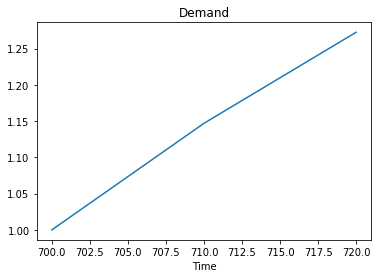

In [7]:
beta = 0.7 # an elasticity of demand
gdp = pd.Series([1., 1.21631, 1.4108], index=pd.Index(horizon, name='Time'))
demand_profile = gdp ** beta
demand_profile.plot(title='Demand')

The `COMMODITY_BALANCE` equation ensures that `input`, `output`, and `demand` are met at each `level` in the energy system

$\begin{split}\sum_{\substack{n^L,t,m \\ y^V \leq y}} output_{n^L,t,y^V,y,m,n,c,l}
     \cdot & ACT_{n^L,t,y^V,y,m} \\
- \sum_{\substack{n^L,t,m, \\ y^V \leq y}} input_{n^L,t,y^V,y,m,n,c,l}
     \cdot & ACT_{n^L,t,m,y} \\
- \ demand_{n,c,l,y}
& \geq 0 \quad \forall \ l \in L\end{split}$

First we establish demand. Let's assume

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- similar per capita demand for lighting as a developed country today (e.g., ~6000 GWh in Austria)

Then we can add the demand parameter

In [8]:
demand_per_year = 3.8e7

light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': demand_per_year * demand_profile,
        'unit': 'GWa',
    })

scenario.add_par("demand", light_demand)

In [9]:
#TODO Hide this one

vintage_years, act_years = scenario.vintage_and_active_years()

base_input = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

base_output = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_dest': country,
    'time': 'year',
    'time_dest': 'year', 
    'unit': '%',
}

Working backwards along the Reference Energy System, we can add connections for the `bulb`

In [10]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  level='final', value=1.0, unit='%')
scenario.add_par('input', bulb_in)

Next, the `grid`, with loses of 13%

In [11]:
grid_efficiency = 0.87
grid_out = make_df(base_output, technology='grid', commodity='electricity', level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',  level='secondary', value=1.0, unit='%')
scenario.add_par('input', grid_in)

And finally, our power plants which are not resource constrained in this simple model thus have no `input`

In [12]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', level='secondary', value=1.)
scenario.add_par('output', coal_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', level='secondary', value=1.)
scenario.add_par('output', wind_out)

## Operational Constraints and Parameters

The model has a number of "reality" constraints, which relate built capacity to available power.

The `CAPACITY_CONSTRAINT` 

$\sum_{m} ACT_{n,t,y^V,y,m,h}
    \leq duration\_time_{h} \cdot capacity\_factor_{n,t,y^V,y,h} \cdot CAP_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$
    
TODO: needed? asked daniel, wait for reply

Operation Constraint

$\sum_{m,h} ACT_{n,t,y^V,y,m,h}
    \leq operation\_factor_{n,t,y^V,y} \cdot capacity\_factor_{n,t,y^V,y,m,\text{'year'}} \cdot CAP_{n,t,y^V,y}$

This requires us to provide capacity factors

In [13]:
#TODO: Hide this
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '%',
}

In [14]:
capacity_factor = {
    'coal_ppl': 0.85,
    'wind_ppl': 0.2,
    'bulb': 0.1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

## Technological Diffusion and Contraction

We know from historical precedent that energy systems can not be transformed instantaneously. Therefore, we use a family of constraints on **activity** (`ACT`) and **capacity** (`CAP`). 

$\begin{split}\sum_{y^V \leq y,m} ACT_{n,t,y^V,y,m,h}
    \leq & ~ initial\_activity\_up_{n,t,y,h}
        \cdot \frac{ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} - 1 }
                   { growth\_activity\_up_{n,t,y,h} } \\
        & + \bigg( \sum_{y^V \leq y-1,m} ACT_{n,t,y^V,y-1,m,h}
                    + \sum_{m} historical\_activity_{n,t,y-1,m,h} \bigg) \\
        & \hspace{2 cm} \cdot \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} \end{split}$

This example limits the ability for technologies to **grow**. It also allows new technologies to penetrate the market based on the `initial_activity_up` paramter. For the purposes of this simple model, we simply need to provide `growth_activity_up` values, which limit the rate technologies can grow.

In [15]:
## TODO: hide this
base_growth = {
    'node_loc': country,
    'year_act': horizon[1:],
    'time': 'year',
}

In [16]:
growth_technologies = [
    "coal_ppl", 
    "wind_ppl", 
    "bulb",
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.05, unit='%') # TODO: is this actually right? should be fraction?
    scenario.add_par('growth_activity_up', df)

## Defining an Energy Mix

The simplest way to model a pre-defined energy mix is to use equality constraints on activity or capacity.

More elegant ways include using parameters to define `historical` values, but in this simple example, we choose a starting point for the Westerosi energy system.

$\sum_{y^V \leq y} ACT_{n,t,y^V,y,m,h} \geq bound\_activity\_lo_{n,t,y,m,h}$

and

$\sum_{y^V \leq y} ACT_{n,t,y^V,y,m,h} \leq bound\_activity\_up_{n,t,m,y,h}$

In [17]:
# TODO: hide

base_activity = {
    'node_loc': country,
    'year_act': [horizon[0]],
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}


In [18]:
total_demand = demand_per_year / grid_efficiency

# in GWh - from IEA Electricity Output
activity = {
    'coal_ppl': 0.5 * total_demand,
    'wind_ppl': 0.5 * total_demand,
}

for tec, val in activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('bound_activity_up', df)
    scenario.add_par('bound_activity_lo', df)

## Objective Function

The objective function seeks to minimize total discounted system cost over space and time. 

$\min \sum_{n,y \in Y^{M}} interestrate_{y} \cdot COST\_NODAL_{n,y}$


Let's add the interest rate parameter.

In [19]:
rate = [0.05] * len(horizon)
unit = ['%'] * len(horizon)
scenario.add_par("interestrate", key=horizon, val=rate, unit=unit)

`COST_NODAL` is comprised of a variety of costs related to the use of different technologies, notably

- Investment Costs

$inv\_cost_{n,t,y} \cdot construction\_time\_factor_{n,t,y} \cdot end\_of\_horizon\_factor_{n,t,y} \cdot CAP\_NEW_{n,t,y}$

In [20]:
# TODO hide this
base_inv_cost = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'USD/GWa',
}

In [21]:
# in $ / kW
costs = {
    'coal_ppl': 1500,
    'wind_ppl': 1100,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val * 1e6)
    scenario.add_par('inv_cost', df)

- Fixed O&M Costs

$\sum_{y^V \leq y} \ fix\_cost_{n,t,y^V,y} \cdot CAP_{n,t,y^V,y}$

In [22]:
# TODO Hide
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/GWa',
}


In [23]:

# in $ / kW
costs = {
    'coal_ppl': 40,
    'wind_ppl': 40,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val * 1e6)
    scenario.add_par('fix_cost', df)

- Variable O&M Costs

$\sum_{\substack{y^V \leq y \\ m,h}} \ var\_cost_{n,t,y^V,y,m,h} \cdot ACT_{n,t,y^V,y,m,h} $

In [24]:
# TODO hide
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/GWa',
}

In [25]:
# in $ / MWh
costs = {
    'coal_ppl': 24.4,
    'grid': 47.8,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val * 8760. * 1e3)
    scenario.add_par('var_cost', df)

A full model will also have costs associated with

- resource extraction: $\sum_{c,g} \ resource\_cost_{n,c,g,y} \cdot EXT_{n,c,g,y} $
- emissions: $\sum_{\substack{\widehat{e},\widehat{t} \\ e \in E(\widehat{e})}}
        emission\_scaling_{\widehat{e},e} \cdot \ emission\_tax_{n,\widehat{e},\widehat{t},y}
        \cdot EMISS_{n,e,\widehat{t},y}$
- land use (emulator): $\sum_{s} land\_cost_{n,s,y} \cdot LAND_{n,s,y}$
- exceedence on "hard" bounds of technology expansion and contraction: $\sum_{m,h} \ \Big( abs\_cost\_activity\_soft\_lo_{n,t,y,m,h} + level\_cost\_activity\_soft\_lo_{n,t,y,m,h} \cdot\ levelized\_cost_{n,t,y,m,h}\Big) \cdot ACT\_LO_{n,t,y,h}$

## Additional Parameters

In order for the mechanics of the model to work, there are some additional parameters that need to be defined. Specifically in this case, we need to provide `technical_lifetime`s for our various energy technologies.

In [26]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'y',
}

In [27]:
lifetimes = {
    'coal_ppl': 20,
    'wind_ppl': 10,
    'bulb': 1,
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

## Commit the datastructure and solve the model

In [28]:
scenario.commit(comment='basic model of Westerosi electrification')
scenario.set_as_default()

In [29]:
scenario.solve('MESSAGE')

In [30]:
scenario.var('OBJ')['lvl']

7.383997797797724e+17

# Plotting Results

In [31]:
from tools import Plots
p = Plots(scenario, country)

In [32]:
plants = ['coal_ppl', 'wind_ppl']
lights = ['bulb']

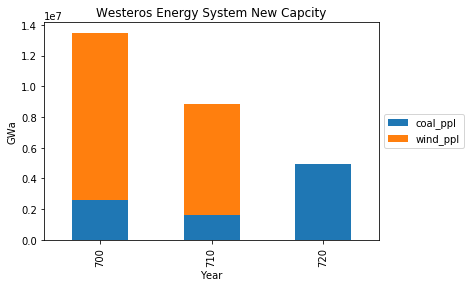

In [33]:
p.plot_new_capacity(baseyear=True, subset=plants)

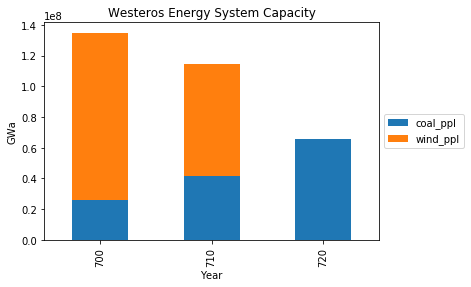

In [34]:
p.plot_capacity(baseyear=True, subset=plants)

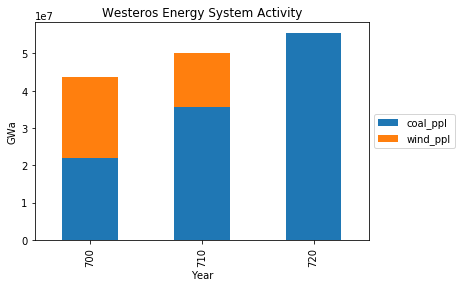

In [35]:
p.plot_activity(baseyear=True, subset=plants)

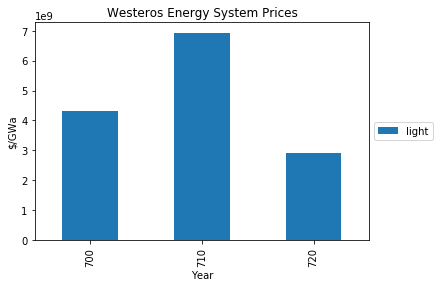

In [36]:
p.plot_prices(subset=['light'], baseyear=True)

In [37]:
mp.close_db()